In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings

from sklearn.preprocessing import LabelEncoder, FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    train_test_split,
    learning_curve,
    RandomizedSearchCV
)
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    confusion_matrix,
    classification_report
)
from sklearn.calibration import calibration_curve
from lime.lime_text import LimeTextExplainer
from IPython.display import HTML, display

# For SMOTE in pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

warnings.filterwarnings('ignore')
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [2]:
# Load and preprocess data
df = pd.read_csv("../Data/Preprocessed_Manual_Labelled_Dataset .csv")
df['text'] = (
    df['cleaned_text']
      .astype(str)
      .str.replace(r'\s+', ' ', regex=True)
      .str.strip()
)

# Label encoding
le = LabelEncoder()
df['y'] = le.fit_transform(df['label'])

print("Classes:", le.classes_)
print("Counts:\n", df['y'].value_counts(), "\n")

Classes: ['Anxiety' 'Depression' 'Normal']
Counts:
 y
2    1019
1     800
0     798
Name: count, dtype: int64 



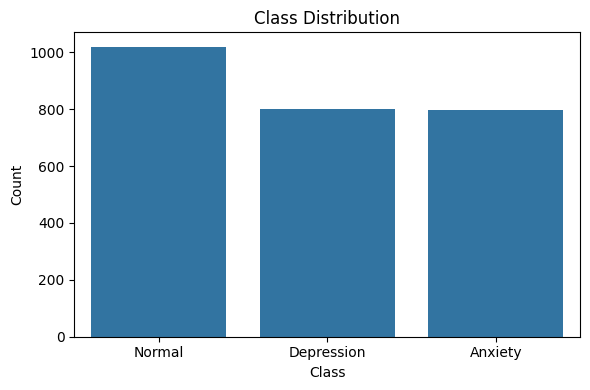

In [3]:
# Visualize class distribution
plt.figure(figsize=(6,4))
sns.barplot(
    x=df['label'].value_counts().index,
    y=df['label'].value_counts().values
)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [4]:
# Define Stemmer (Sinhala language)
COMMON_SUFFIXES = [
    'වූ','වෙන','වෙයි','වුණ','න්න','නුම්',
    'වී','යේ','යුතු','පුළුවන්','කරන','කරයි',
    'හු','වරු','ලා','වල්','ගේ','ට','ගෙන්','ළඟ',
    'එක','යි','ද','ක්','ම','ටයි','තුමා'
]

def stem_and_join(text: str) -> str:
    tokens, stems = text.split(), []
    for tok in tokens:
        stem = tok
        for suf in COMMON_SUFFIXES:
            if stem.endswith(suf) and len(stem) - len(suf) >= 2:
                stem = stem[:-len(suf)]
                break
        stems.append(stem)
    return " ".join(stems)

In [5]:
# Named transformer so pipeline is picklable
def transform_stems(X):
    return [stem_and_join(x) for x in X]

# Train/Test Split
X_raw     = df['text']
X_stemmed = df['text'].map(stem_and_join)
y         = df['y']

X_tr_raw, X_te_raw, X_tr_stem, X_te_stem, y_train, y_test = train_test_split(
    X_raw, X_stemmed, y,
    test_size=0.20,
    stratify=y,
    random_state=RANDOM_STATE
)
print(f"Training: {len(X_tr_raw)} raw, {len(X_tr_stem)} stemmed")
print(f"Testing : {len(X_te_raw)} raw, {len(X_te_stem)} stemmed\n")

Training: 2093 raw, 2093 stemmed
Testing : 524 raw, 524 stemmed



In [6]:
# TF-IDF settings (min token length ≥ 3)
TFIDF_ARGS = dict(
    token_pattern=r'(?u)\b\w{3,}\b',   # only tokens of 3+ characters
    ngram_range=(1,2),
    max_features=3000,
    sublinear_tf=True
)

# Precompute TF-IDF features
tfidf = TfidfVectorizer(**TFIDF_ARGS)
X_tr_tfidf = tfidf.fit_transform(X_tr_stem)
X_te_tfidf = tfidf.transform(X_te_stem)

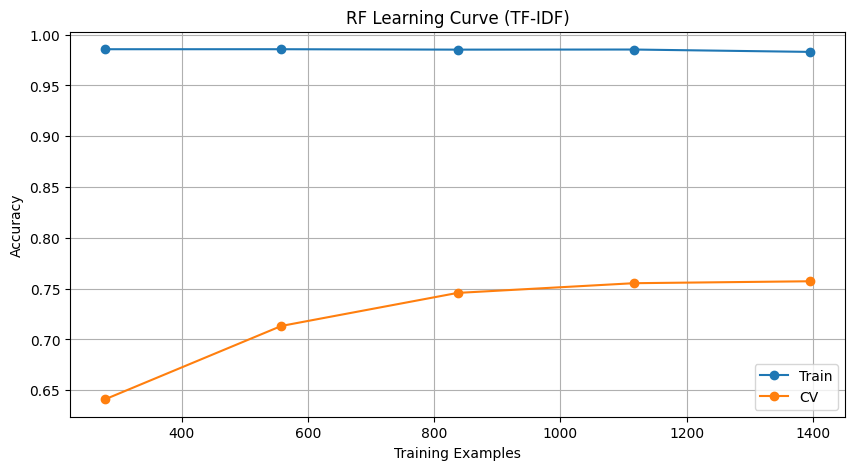

In [7]:
# Learning curve helper
def plot_learning_curve(estimator, X, y, cv=3, title="Learning Curve"):
    from sklearn.model_selection import learning_curve as lc
    train_sizes, train_scores, val_scores = lc(
        estimator, X, y,
        train_sizes=np.linspace(0.2,1.0,5),
        cv=cv,
        scoring='accuracy',
        shuffle=True,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    plt.figure(figsize=(10,5))
    plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', label='Train')
    plt.plot(train_sizes, val_scores.mean(axis=1),   'o-', label='CV')
    plt.title(title)
    plt.xlabel("Training Examples")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

# Baseline Learning Curve
rf_base = RandomForestClassifier(
    random_state=RANDOM_STATE, n_estimators=100
)
plot_learning_curve(
    rf_base, X_tr_tfidf, y_train,
    cv=3, title="RF Learning Curve (TF‑IDF)"
)

In [8]:
# Hyperparameter tuning with SMOTE toggle
pipe = ImbPipeline([
    ('stem',   FunctionTransformer(transform_stems, validate=False)),
    ('tfidf',  TfidfVectorizer(**TFIDF_ARGS)),
    ('smote',  SMOTE(random_state=RANDOM_STATE)),
    ('clf',    RandomForestClassifier(
                   class_weight='balanced',
                   random_state=RANDOM_STATE
               ))
])

param_dist = {
    'smote':               [SMOTE(random_state=RANDOM_STATE), 'passthrough'],
    'clf__n_estimators':   [100, 200],
    'clf__max_depth':      [None, 20],
    'clf__min_samples_split':[2, 5],
    'clf__min_samples_leaf':[1, 2],
    'clf__max_features':   ['sqrt', 0.5]
}

search = RandomizedSearchCV(
    pipe,
    param_distributions=param_dist,
    n_iter=30,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=2,
    random_state=RANDOM_STATE
)
# Fit on RAW text; pipeline handles stemming & TF‑IDF internally
search.fit(X_tr_raw, y_train)
best_params = search.best_params_
print("Best hyperparameters:", best_params, "\n")

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100, smote=SMOTE(random_state=42); total time=   1.0s
[CV] END clf__max_depth=None, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100, smote=SMOTE(random_state=42); total time=   1.1s
[CV] END clf__max_depth=20, clf__max_features=0.5, clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=100, smote=SMOTE(random_state=42); total time=   1.5s
[CV] END clf__max_depth=20, clf__max_features=0.5, clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=100, smote=SMOTE(random_state=42); total time=   1.5s
[CV] END clf__max_depth=20, clf__max_features=0.5, clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=100, smote=SMOTE(random_state=42); total time=   1.6s
[CV] END clf__max_depth=20, clf__max_features=sqrt, clf__min_sa

In [9]:
# Final evaluation
best_model = search.best_estimator_
y_pred     = best_model.predict(X_te_raw)
y_proba    = best_model.predict_proba(X_te_raw)

acc  = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average='weighted'
)
roc  = roc_auc_score(
    y_test, y_proba,
    multi_class='ovr', average='weighted'
)

print(f"Test Accuracy : {acc:.3f}")
print(f"Precision     : {prec:.3f}")
print(f"Recall        : {rec:.3f}")
print(f"F1‑Score      : {f1:.3f}")
print(f"ROC‑AUC       : {roc:.3f}\n")
print("Classification Report:\n",
      classification_report(
          y_test, y_pred, target_names=le.classes_
      )
)

Test Accuracy : 0.823
Precision     : 0.822
Recall        : 0.823
F1‑Score      : 0.820
ROC‑AUC       : 0.921

Classification Report:
               precision    recall  f1-score   support

     Anxiety       0.82      0.72      0.77       160
  Depression       0.82      0.78      0.80       160
      Normal       0.83      0.94      0.88       204

    accuracy                           0.82       524
   macro avg       0.82      0.81      0.81       524
weighted avg       0.82      0.82      0.82       524



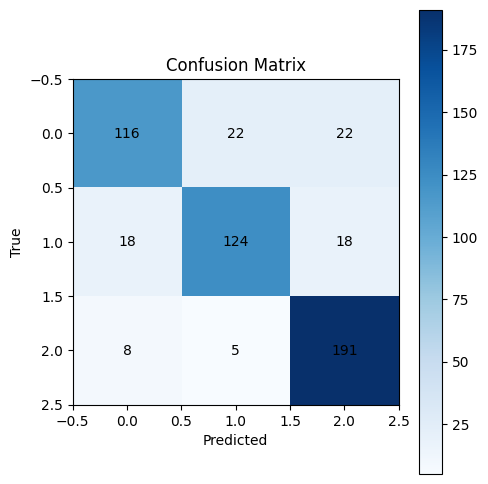

In [10]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted'); plt.ylabel('True')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i,j], ha='center', va='center')
plt.colorbar()
plt.tight_layout()
plt.show()

In [11]:
# End-to-End Pipeline + LIME Explanation
rf_tuned = RandomForestClassifier(
    random_state=RANDOM_STATE,
    class_weight='balanced',
    **{k.split('__')[-1]: v for k,v in best_params.items() if k.startswith('clf__')}
)
full_pipe = Pipeline([
    ('stem',   FunctionTransformer(transform_stems, validate=False)),
    ('tfidf',  TfidfVectorizer(**TFIDF_ARGS)),
    ('clf',    rf_tuned)
])
full_pipe.fit(X_tr_raw, y_train)

# Create LIME explainer for interpretability
explainer = LimeTextExplainer(
    class_names=le.classes_,
    split_expression=r'\s+'  # Only split on whitespace (whole stems as tokens)
)

# Explain a test instance
idx = 5
exp = explainer.explain_instance(
    X_te_raw.iloc[idx],
    full_pipe.predict_proba,
    num_features=10,
    num_samples=300
)

# Print the top contributing stems
print("\nTop contributing stems:")
for tok, wt in exp.as_list():
    print(f"  {tok:>8s} → {wt:+.4f}")

# Display the interactive HTML highlights
display(HTML(exp.as_html()))


Top contributing stems:
      ආදරේ → +0.1530
   අතහැරලා → +0.0951
      යනවා → +0.0832
    කරගන්න → +0.0227
     අසමත් → -0.0181
  අසාර්ථකයි → -0.0099
     අතින් → +0.0098
      බැහැ → -0.0088
   පන්තියේ → -0.0074
   දරුවෙක් → +0.0072


In [12]:
# Save artifacts for deployment
with open('rf_model.pkl','wb') as f:
    pickle.dump(best_model, f)
with open('tfidf_vectorizer.pkl','wb') as f:
    pickle.dump(tfidf, f)
with open('label_encoder.pkl','wb') as f:
    pickle.dump(le, f)
with open('full_pipeline.pkl','wb') as f:
    pickle.dump(full_pipe, f)

print("All artifacts saved.")

All artifacts saved.


In [13]:
# Additional diagnostic plots
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Binarize true labels for multiclass metrics
y_test_bin = label_binarize(y_test, classes=np.arange(len(le.classes_)))
# Predicted probabilities from the best pipeline
probs = best_model.predict_proba(X_te_raw)

colors = ['navy', 'darkorange', 'green']

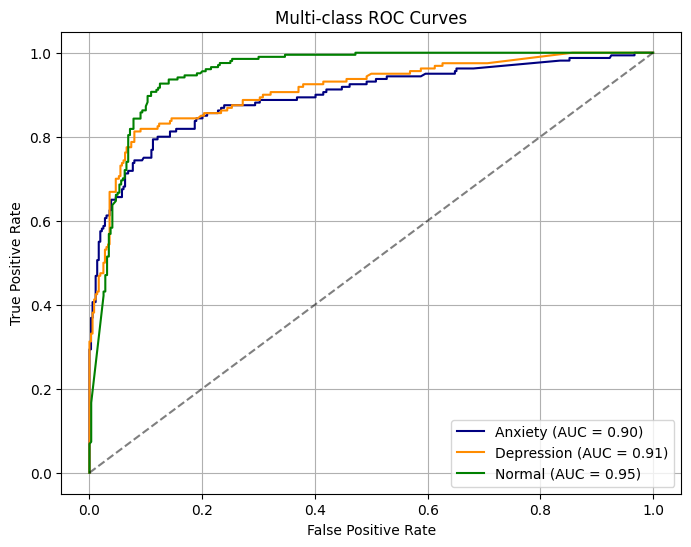

In [14]:
# Multi-class ROC Curves
plt.figure(figsize=(8,6))
for i, color in enumerate(colors):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color,
             label=f'{le.classes_[i]} (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--', alpha=0.5)
plt.title('Multi‑class ROC Curves')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.legend(loc='lower right'); plt.grid(True)
plt.show()

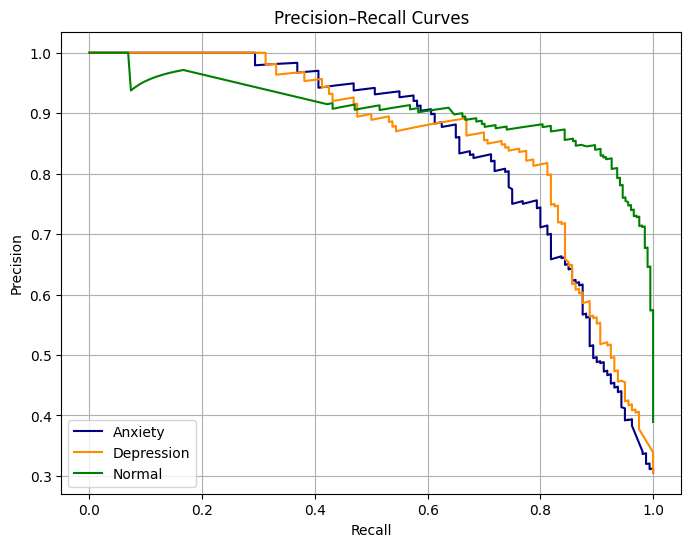

In [15]:
# Precision–Recall Curves
plt.figure(figsize=(8,6))
for i, color in enumerate(colors):
    precision, recall, _ = precision_recall_curve(
        y_test_bin[:, i], probs[:, i]
    )
    plt.plot(recall, precision, color=color,
             label=f'{le.classes_[i]}')
plt.title('Precision–Recall Curves')
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.legend(loc='lower left'); plt.grid(True)
plt.show()

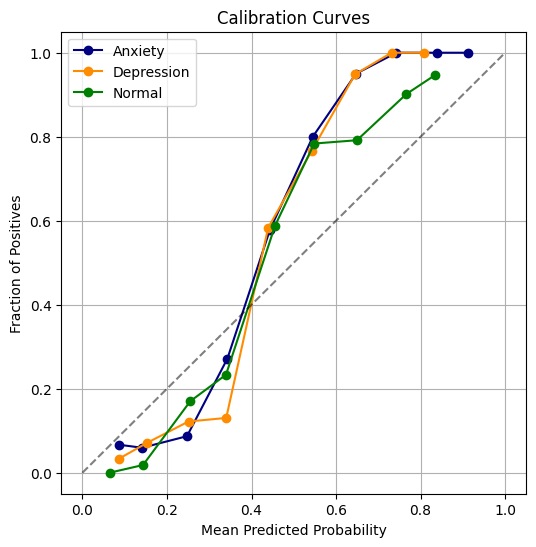

In [16]:
# Calibration Curves
plt.figure(figsize=(6,6))
for i, color in enumerate(colors):
    prob_true, prob_pred = calibration_curve(
        y_test_bin[:, i], probs[:, i], n_bins=10
    )
    plt.plot(prob_pred, prob_true, marker='o', color=color,
             label=le.classes_[i])
plt.plot([0,1], [0,1], 'k--', alpha=0.5)
plt.title('Calibration Curves')
plt.xlabel('Mean Predicted Probability'); plt.ylabel('Fraction of Positives')
plt.legend(); plt.grid(True)
plt.show()

In [17]:
# Feature Importances
importances = best_model.named_steps['clf'].feature_importances_
indices     = np.argsort(importances)[::-1][:20]
feat_names  = tfidf.get_feature_names_out()[indices]
scores      = importances[indices]

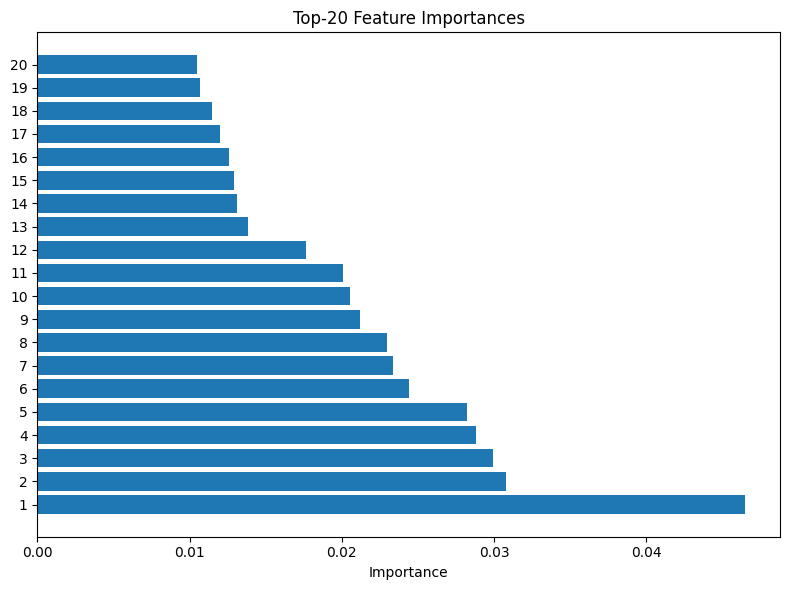

In [18]:
# Plot with numeric labels
plt.figure(figsize=(8,6))
nums = np.arange(1, len(feat_names) + 1)
plt.barh(nums[::-1], scores[::-1])
plt.yticks(nums[::-1], [str(n) for n in nums[::-1]], fontsize=10)
plt.title('Top‑20 Feature Importances')
plt.xlabel('Importance'); plt.tight_layout()
plt.show()

In [19]:
# Mapping from number → Sinhala stem
print("Feature # → Sinhala stem")
for num, name in zip(nums, feat_names):
    print(f"{num:2d}: {name}")

Feature # → Sinhala stem
 1: තරම
 2: ටවත
 3: කලබල
 4: ලනව
 5: කනස
 6: අඬනව
 7: කරග
 8: නවත
 9: කරන
10: එනව
11: යනව
12: දවස
13: කණස
14: ඩනය
15: කවද
16: දහඩ
17: ආදර
18: බලන
19: පටන
20: මහන


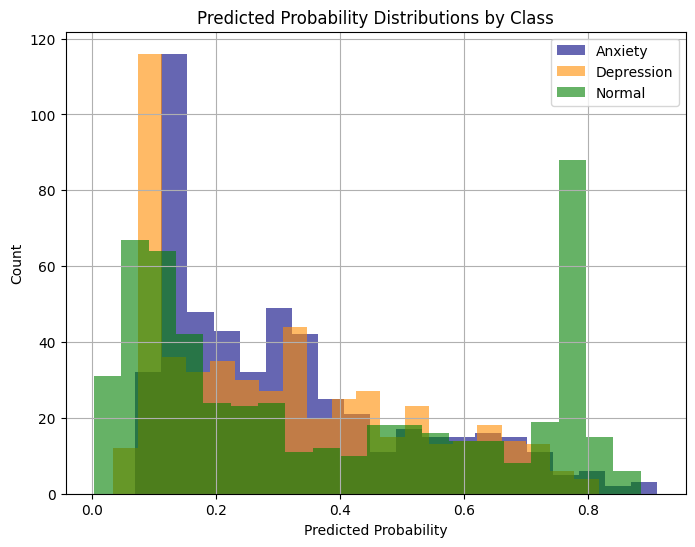

In [20]:
# Class Probability Histograms
plt.figure(figsize=(8,6))
for i, color in enumerate(colors):
    plt.hist(probs[:, i], bins=20, alpha=0.6, label=le.classes_[i], color=color)
plt.title('Predicted Probability Distributions by Class')
plt.xlabel('Predicted Probability'); plt.ylabel('Count')
plt.legend(); plt.grid(True)
plt.show()